# Capstone: West Nile Virus Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [700]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn import naive_bayes
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import date

import tensorflow as tf

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

import pickle
from tkinter import Tk
from tkinter.filedialog import askopenfilename

## Data Loading and Cleaning

### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [54]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [55]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [56]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [129]:
weather = pd.read_csv('./datasets/weather.csv')
weather.head(30)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [57]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))


# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head()

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,41.995,-87.933,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,41.786,-87.752,60,43,51.5,M,42,47,13,0,-,-,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,41.995,-87.933,66,46,56.0,2,40,48,9,0,0446,1851,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [59]:
# Reformatting weather data into flattened version for merging with train data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))

weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


#### PCA
Many weather features to comprehend, some of which are highly correlated as evidenced by the heatmap.
We will use the cumulated explained_variance_ratio to test this

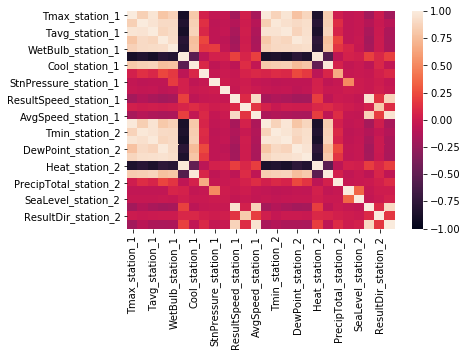

In [131]:
# Prepare a weather_pca dataframe with string dtypes converted to numeric, and standardise:
weather_pca = weather_df.drop(columns=['Station_station_1','Station_station_2',
                                       'Latitude_station_1','Longitude_station_1',
                                       'Latitude_station_2','Longitude_station_2',
                                       'Depth_station_1','Water1_station_1',
                                       'Depth_station_2','Water1_station_2',
                                       'Sunrise_station_1','Sunset_station_1',
                                       'Sunrise_station_2','Sunset_station_2',
                                       'Depart_station_1','Depart_station_2',
                                       'SnowFall_station_1','SnowFall_station_2',
                                       'CodeSum_station_1','CodeSum_station_2']).replace({'M':0,'  T':0, '-':0}).apply(pd.to_numeric)
scaler = StandardScaler()
weather_pca = pd.DataFrame(scaler.fit_transform(weather_pca), columns=weather_pca.columns)

# Check heatmap for any correlations that would be helped with PCA:
sns.heatmap(weather_pca.corr(), vmin=-1, vmax=1);

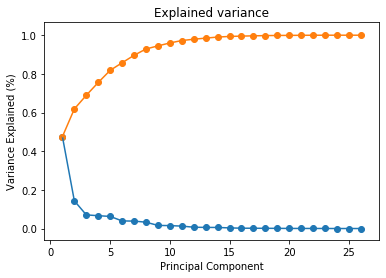

In [252]:
# Fit PCA model and assess:
pca = PCA()
pca.fit(weather_pca)

# Plot the explained_variance_ratio_
x_values = list(range(1, pca.n_components_+1))
plt.plot(x_values, pca.explained_variance_ratio_)
plt.scatter(x_values, pca.explained_variance_ratio_)
plt.plot(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.scatter(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

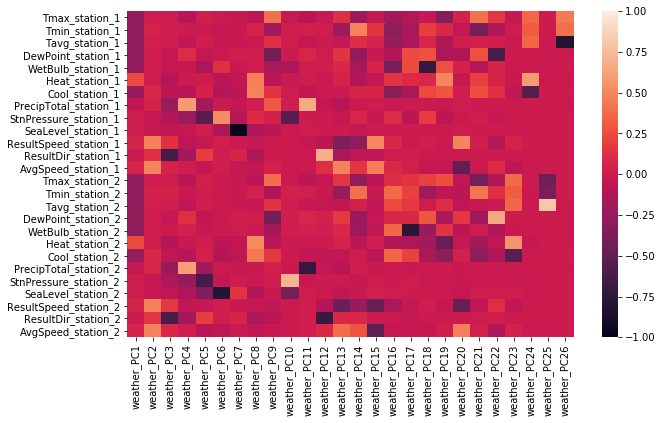

In [370]:
weather_dict = {'weather_PC'+str(i+1): pca.components_[i] for i in range(len(pca.components_))}
weather_pca_df = pd.DataFrame(weather_dict, index=weather_pca.columns)

weather_pcs = pd.DataFrame(pca.transform(weather_pca),
                           columns=['weather_PC'+str(i+1) for i in range(len(weather_pca.columns))],
                           index=weather_df.index)
plt.figure(figsize=(10,6))
sns.heatmap(weather_pca_df, vmin=-1, vmax=1, );

### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [63]:
spray = pd.read_csv('./datasets/spray.csv')
spray['Time'] = spray['Time'].fillna(value=spray.mode().Time[0])
spray['DateTime'] = spray.apply(lambda x: str(x['Date'])+' '+str(x['Time']), axis=1)
spray['DateTime'] = spray.apply(lambda x: datetime.strptime(str(x['DateTime']), '%Y-%m-%d %I:%M:%S %p'), axis=1)
spray['Date'] = spray.apply(lambda x: datetime.strptime(str(x['Date']), '%Y-%m-%d'), axis=1)
spray['Latitude2'] = np.round(spray.Latitude,2)
spray['Longitude2'] = np.round(spray.Longitude,2)
spray.set_index('DateTime', inplace=True, drop=True)
spray.head(1)

,Date,Time,Latitude,Longitude,Latitude2,Longitude2
DateTime,,,,,,
2011-08-29 18:56:58,2011-08-29,6:56:58 PM,42.391623,-88.089163,42.39,-88.09


## EDA: visualise and analyse data

### Prepare train dataframe

In [135]:
# Merging weather data onto train data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
# Merging weather_pcs data onto train data:
train_df = train_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
train_df.head(1)
# Merging spray data onto train data:
train_df['Latitude2'] = np.round(train_df.Latitude,2)
train_df['Longitude2'] = np.round(train_df.Longitude,2)
spray_df = spray.drop_duplicates(subset=['Date','Latitude2','Longitude2'])
train_df = train_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
train_df['isSpray'] = [0 if x==0 else 1 for x in train_df.Time.fillna(value=0)]
train_df.set_index('Date', inplace=True, drop=True)
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2,weather_PC1,weather_PC2,weather_PC3,weather_PC4,weather_PC5,weather_PC6,weather_PC7,weather_PC8,weather_PC9,weather_PC10,weather_PC11,weather_PC12,weather_PC13,weather_PC14,weather_PC15,weather_PC16,weather_PC17,weather_PC18,weather_PC19,weather_PC20,weather_PC21,weather_PC22,weather_PC23,weather_PC24,weather_PC25,weather_PC26,Latitude2,Longitude2,Time,Latitude_spray,Longitude_spray,isSpray
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4,-2.597497,-0.583877,0.097459,-0.756588,-0.023922,-0.100406,-0.173416,0.145576,0.464665,-0.045627,-0.089957,0.02089,-0.019865,-0.354337,-0.243011,0.184774,0.03629,-0.081355,-0.096362,0.150023,-0.01562,0.024673,0.003364,0.021722,2.047035e-17,5.391743e-16,41.95,-87.8,NaN,NaN,NaN,0


### Autocorrelation: investigating seasonality
Plotting Partial Autocorrelation for number of mosquitos found in traps shows little seasonal effects that can be leveraged in predictions

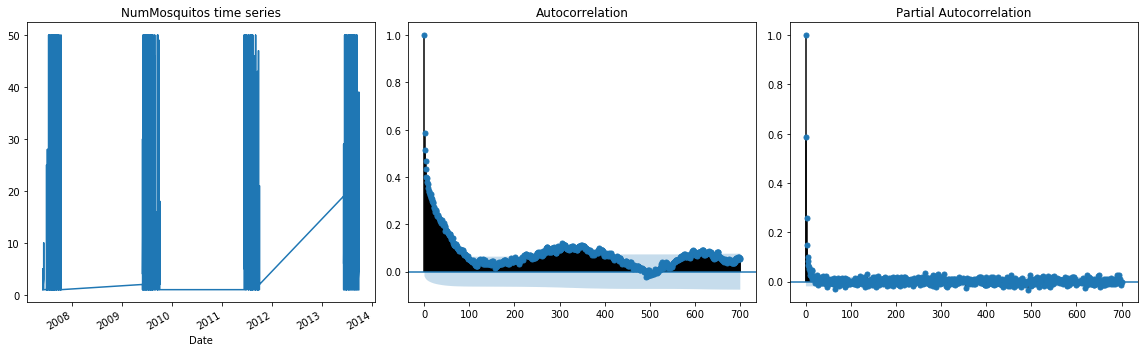

In [663]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

train_df['NumMosquitos'].plot(ax=ax[0], title='NumMosquitos time series')
plot_acf(train_df['NumMosquitos'], lags=700, ax=ax[1])
plot_pacf(train_df['NumMosquitos'], lags=700, ax=ax[2])

plt.tight_layout()
plt.show()

### Scatter plots

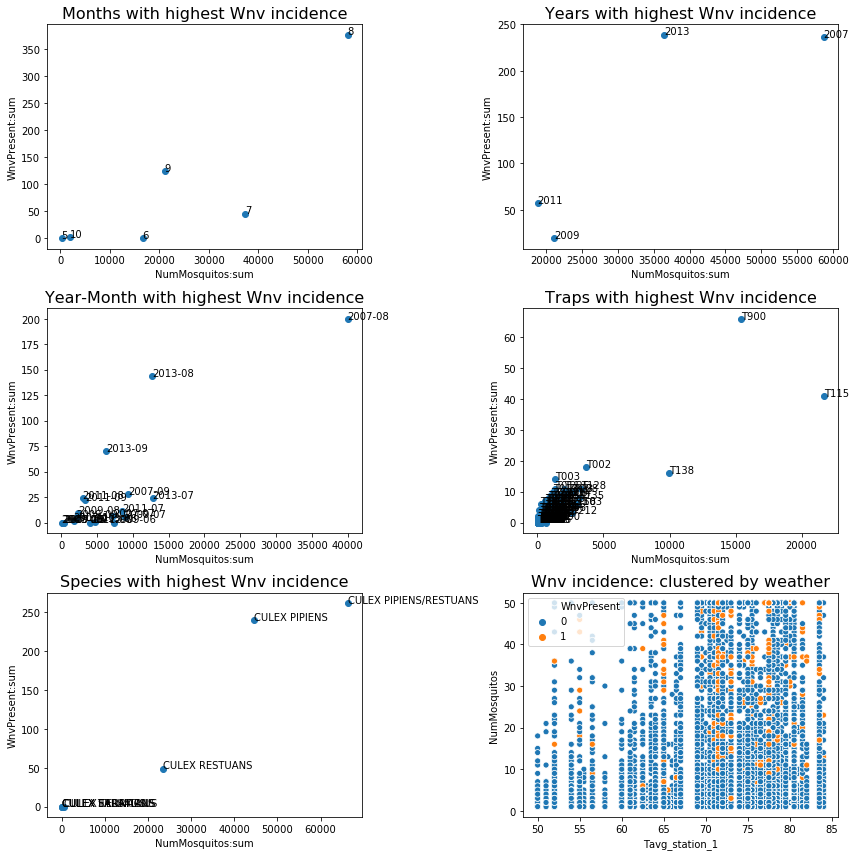

In [417]:
# When (ie, which summer month / which year) had the highest incidence of Wnv and NumMosquitos?
# And where (ie, which trap) had the highest incidence of Wnv and NumMosquitos?

train_month_grp = train.groupby(train.index.month).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.tight_layout()
plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

## Modelling

#### Setting up (X, y)

In [743]:
y, X = train_df['WnvPresent'], train_df[['Species','Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4',
                                         'weather_PC5','weather_PC6','weather_PC7','weather_PC8',
                                         'weather_PC9','weather_PC10','isSpray']]
X_dum = pd.get_dummies(X, drop_first=True, columns=['Species','Trap'])

# initialise classes generic to all models below:
std = StandardScaler()
sm = SMOTENC(categorical_features=list(range(10,152)))
ovr = RandomOverSampler()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Sci-kit Learn GridSearchCV tuning classifiers

#### Logistic Regression

In [745]:
lr = LogisticRegression(fit_intercept=False)
params = {'sm__sampling_strategy':[0.5],
          'lr__penalty':['l2'],
          'lr__C':[0.1]}
#          'lr__C':np.logspace(-4,-1,4)}

pipeline = Pipeline([('std', std), ('sm', sm), ('lr', lr)])

gs_lr = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_lr.fit(X_dum, y)
print(gs_lr.best_params_)
print(gs_lr.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.7min finished


{'lr__C': 0.1, 'lr__penalty': 'l2', 'sm__sampling_strategy': 0.5}
0.7030817178531895


##### Logistic Regression Results

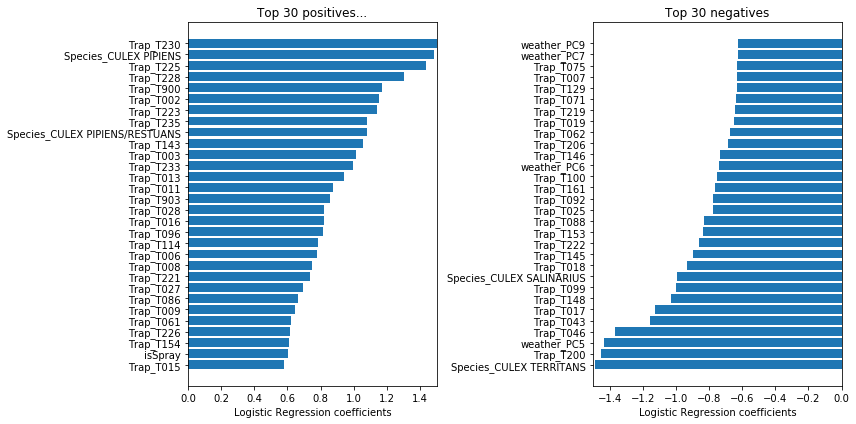

In [699]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_lr_coefficients = pd.DataFrame(gs_lr.best_estimator_.steps[2][1].coef_,
                                  columns=X_dum.columns,
                                  index=['coefficients']).T.sort_values('coefficients',ascending=True)
ax[0].barh(gs_lr_coefficients.iloc[-30:,0].index, gs_lr_coefficients.iloc[-30:,0])
ax[0].set_title('Top 30 positives...')
ax[0].set_xlabel('Logistic Regression coefficients')
ax[0].set_xlim([0,1.5])
ax[1].barh(gs_lr_coefficients.iloc[:30,0].index, gs_lr_coefficients.iloc[:30,0])
ax[1].set_title('Top 30 negatives')
ax[1].set_xlabel('Logistic Regression coefficients')
ax[1].set_xlim([-1.5,0])
fig.tight_layout();

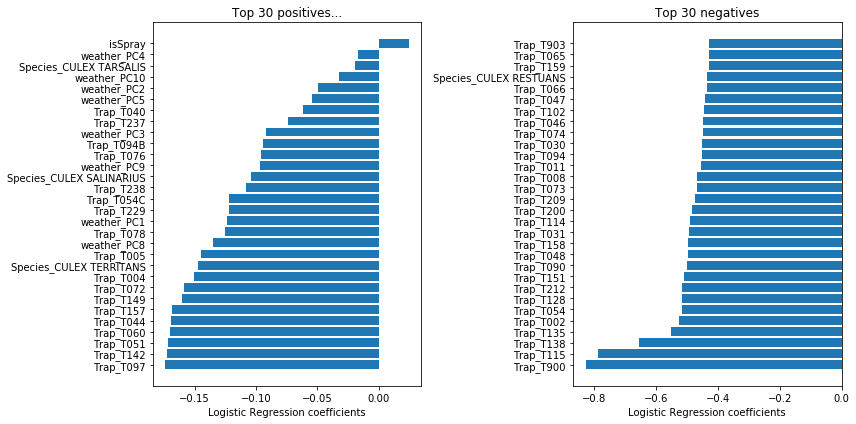

In [746]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_lr_coefficients = pd.DataFrame(gs_lr.best_estimator_.steps[2][1].coef_,
                                  columns=X_dum.columns,
                                  index=['coefficients']).T.sort_values('coefficients',ascending=True)
ax[0].barh(gs_lr_coefficients.iloc[-30:,0].index, gs_lr_coefficients.iloc[-30:,0])
ax[0].set_title('Top 30 positives...')
ax[0].set_xlabel('Logistic Regression coefficients')
#ax[0].set_xlim([0,1.5])
ax[1].barh(gs_lr_coefficients.iloc[:30,0].index, gs_lr_coefficients.iloc[:30,0])
ax[1].set_title('Top 30 negatives')
ax[1].set_xlabel('Logistic Regression coefficients')
#ax[1].set_xlim([-1.5,0])
fig.tight_layout();

In [747]:
sm_best = SMOTENC(categorical_features=list(range(10,139)),
                  sampling_strategy=gs_lr.best_estimator_.steps[1][1].sampling_strategy)
lr_best = LogisticRegression(C=gs_lr.best_estimator_.steps[2][1].C,
                             penalty=gs_lr.best_estimator_.steps[2][1].penalty)
pipe_lr_best = Pipeline([('std', std), ('sm_best', sm_best), ('lr_best', lr_best)])
pipe_lr_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_lr_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_lr_best.predict(X_dum)))

Confusion Matrix:
[[9460  495]
 [ 460   91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9955
           1       0.16      0.17      0.16       551

    accuracy                           0.91     10506
   macro avg       0.55      0.56      0.56     10506
weighted avg       0.91      0.91      0.91     10506



In [457]:
# Pickle if results are satisfactory:
gs_lr_pickle_name = './pickle_objects/gs_lr_best_score_{}%.pkl'.format(np.round(gs_lr.best_score_*100,2))
pickle.dump(gs_lr.best_estimator_, open(gs_lr_pickle_name, 'wb'))

#### Decision Tree Classifier

In [270]:
dt = DecisionTreeClassifier()
params = {'dt__max_depth':range(2,10),
          'dt__max_features':np.linspace(0.1,0.5,4)}

pipeline = Pipeline([('sm', sm), ('dt', dt)])

gs_dt = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_dt.fit(X_dum, y)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed: 43.5min finished


{'dt__max_depth': 9, 'dt__max_features': 0.5}
0.7907379769157771


##### Decision Tree Results

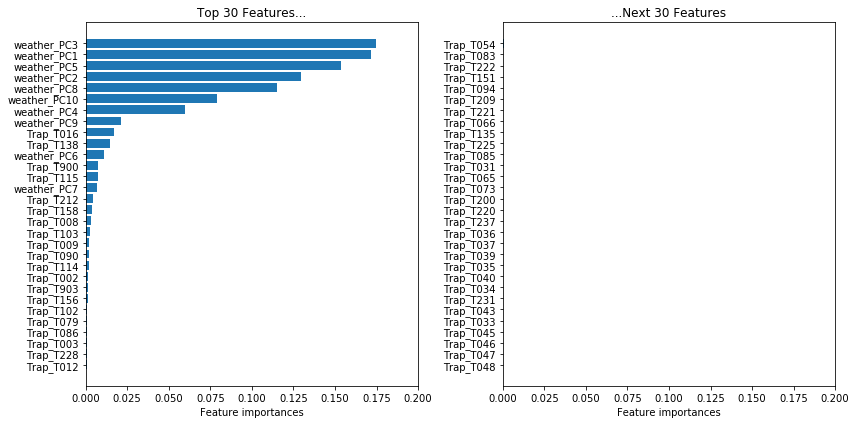

In [392]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_dt_importances = pd.DataFrame(gs_dt.best_estimator_.steps[1][1].feature_importances_,
                                  index=X_dum.columns,
                                  columns=['importances']).sort_values('importances', ascending=True)
ax[0].barh(gs_dt_importances.iloc[-30:,0].index, gs_dt_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_dt_importances.iloc[-60:,:].iloc[:30,0].index, gs_dt_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

In [458]:
# Pickle if results are satisfactory:
gs_dt_pickle_name = './pickle_objects/gs_dt_best_score_{}%.pkl'.format(np.round(gs_dt.best_score_*100,2))
pickle.dump(gs_dt.best_estimator_, open(gs_dt_pickle_name, 'wb'))

#### Random Forest Classifier

In [593]:
rf = RandomForestClassifier(n_estimators=100)
params = {'rf__max_depth': list(range(2,10,5)),
          'rf__min_samples_split': np.linspace(0.3,0.4,3)}

pipeline = Pipeline([('std', std), ('sm', sm), ('rf', rf)])

gs_rf = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_rf.fit(X_dum, y)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  8.9min finished


{'rf__max_depth': 7, 'rf__min_samples_split': 0.35}
0.7554293707432833


##### Random Forest Results

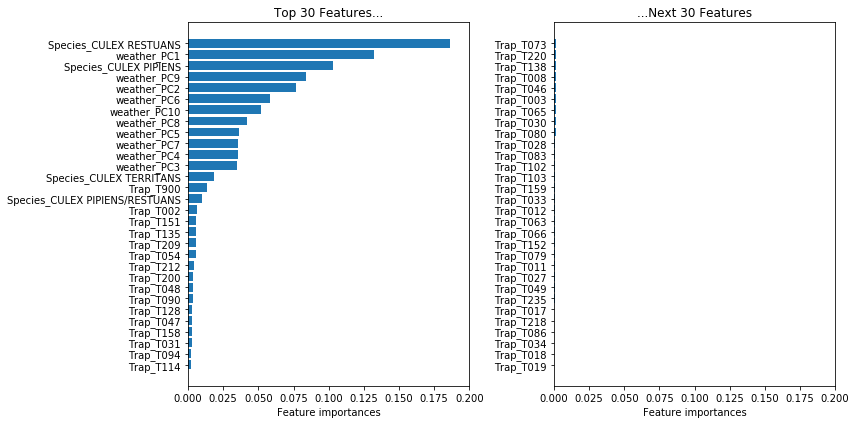

In [595]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_rf_importances = pd.DataFrame(gs_rf.best_estimator_.steps[2][1].feature_importances_,
                                  index=X_dum.columns,
                                  columns=['importances']).sort_values('importances',ascending=True)
ax[0].barh(gs_rf_importances.iloc[-30:,0].index, gs_rf_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_rf_importances.iloc[-60:,:].iloc[:30,0].index, gs_rf_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

In [ ]:
rf_best = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=0.35)
pipe_rf_best = Pipeline([('std', std), ('sm', sm), ('rf_best', rf_best)])
pipe_rf_best.fit(X_dum, y)
print(pipe_rf_best.score(X_dum, y))
pipe_rf_best.predict(X_dum)

In [ ]:
# Pickle if results are satisfactory:
gs_rf_pickle_name = './pickle_objects/gs_rf_best_score_{}%.pkl'.format(np.round(gs_rf.best_score_*100,2))
pickle.dump(gs_rf.best_estimator_, open(gs_rf_pickle_name, 'wb'))

#### Gradient Boosting Classifier

In [748]:
gb = GradientBoostingClassifier(n_estimators=100, n_iter_no_change=20)
params = {'gb__learning_rate': np.linspace(.1,1.,4),
          'gb__max_depth':range(2,10),
          'gb__max_features':np.linspace(0.1,0.5,4)}

pipeline = Pipeline([('std', std), ('sm', sm), ('gb', gb)])

gs_gb = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_gb.fit(X_dum, y)
print(gs_gb.best_params_)
print(gs_gb.best_score_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 61.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 140.0min
[Parallel(n_jobs=2)]: Done 640 out of 640 | elapsed: 200.7min finished


{'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 0.1}
0.8074155937591397


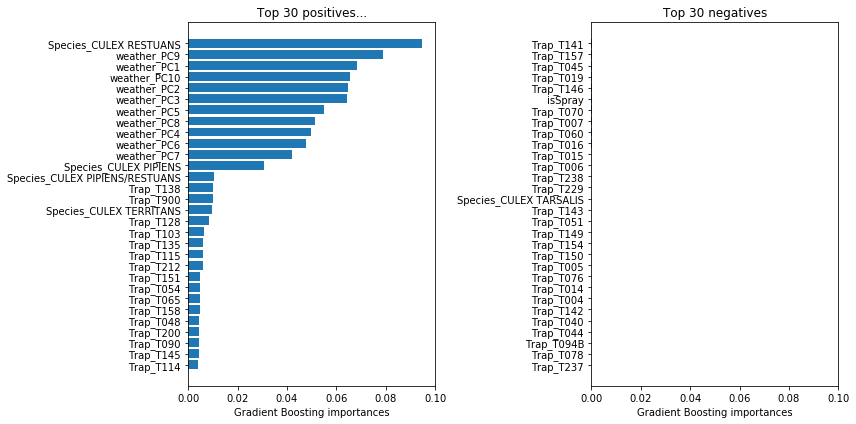

In [759]:
gb_feature_importances = pd.DataFrame(gs_gb.best_estimator_.steps[2][1].feature_importances_,
                                      index=X_dum.columns,
                                      columns=['importances']).sort_values('importances')

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(gb_feature_importances.iloc[-30:,0].index, gb_feature_importances.iloc[-30:,0])
ax[0].set_title('Top 30 positives...')
ax[0].set_xlabel('Gradient Boosting importances')
ax[0].set_xlim([0,0.1])
ax[1].barh(gb_feature_importances.iloc[:30,0].index, gb_feature_importances.iloc[:30,0])
ax[1].set_title('Top 30 negatives')
ax[1].set_xlabel('Gradient Boosting importances')
ax[1].set_xlim([0,0.1])
fig.tight_layout();

In [750]:
sm_best = SMOTENC(categorical_features=list(range(10,152)))
gb_best = GradientBoostingClassifier(n_estimators=100, n_iter_no_change=20,
                                     learning_rate=gs_gb.best_estimator_.steps[2][1].learning_rate,
                                     max_depth=gs_gb.best_estimator_.steps[2][1].max_depth,
                                     max_features=gs_gb.best_estimator_.steps[2][1].max_features)
pipe_gb_best = Pipeline([('std', std), ('sm_best', sm_best), ('gb_best', gb_best)])
pipe_gb_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_gb_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_gb_best.predict(X_dum)))

Confusion Matrix:
[[8900 1055]
 [ 100  451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      9955
           1       0.30      0.82      0.44       551

    accuracy                           0.89     10506
   macro avg       0.64      0.86      0.69     10506
weighted avg       0.95      0.89      0.91     10506



In [733]:
sm_best = SMOTENC(categorical_features=list(range(10,139)))
gb_best = GradientBoostingClassifier(n_estimators=100, n_iter_no_change=20,
                                     learning_rate=gs_gb.best_estimator_.steps[2][1].learning_rate,
                                     max_depth=gs_gb.best_estimator_.steps[2][1].max_depth,
                                     max_features=gs_gb.best_estimator_.steps[2][1].max_features)
pipe_gb_best = Pipeline([('std', std), ('sm_best', sm_best), ('gb_best', gb_best)])
pipe_gb_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_gb_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_gb_best.predict(X_dum)))

Confusion Matrix:
[[8925 1030]
 [  89  462]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9955
           1       0.31      0.84      0.45       551

    accuracy                           0.89     10506
   macro avg       0.65      0.87      0.70     10506
weighted avg       0.95      0.89      0.92     10506



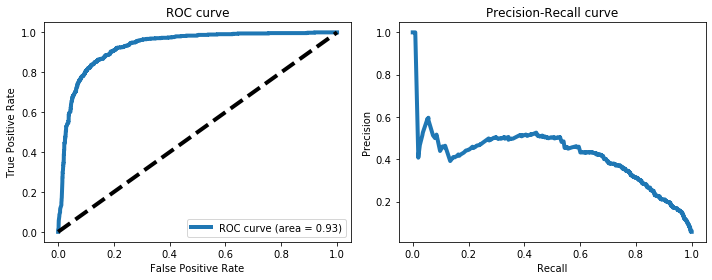

In [751]:
y_pp = pd.DataFrame(pipe_gb_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout()
plt.show()

In [455]:
# Pickle if results are satisfactory:
gs_gb_pickle_name = './pickle_objects/gs_gb_best_score_{}%.pkl'.format(np.round(gs_gb.best_score_*100,2))
pickle.dump(gs_gb.best_estimator_, open(gs_gb_pickle_name, 'wb'))

#### Bagging Classifier

In [176]:
bc = BaggingClassifier(n_estimators=100)
params = {'bc__max_features': np.linspace(0.1,0.2,2)}

pipeline = Pipeline([('std', std), ('sm', sm), ('bc', bc)])

gs_bc = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_bc.fit(X_dum, y)
print(gs_bc.best_params_)
print(gs_bc.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.9min finished


{'bc__max_features': 0.1}
0.8197708484247912


In [456]:
# Pickle if results are satisfactory:
gs_bc_pickle_name = './pickle_objects/gs_bc_best_score_{}%.pkl'.format(np.round(gs_bc.best_score_*100,2))
pickle.dump(gs_bc.best_estimator_, open(gs_bc_pickle_name, 'wb'))

In [666]:
bc_best = BaggingClassifier(n_estimators=100, max_features=0.1)
pipe_bc_best = Pipeline([('std', std), ('sm', sm), ('bc_best', bc_best)])
pipe_bc_best.fit(X_dum, y)
print(pipe_bc_best.score(X_dum, y))
print('Classification Report:')
print(classification_report(y, pipe_bc_best.predict(X_dum)))

0.7699409861031792
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      9955
           1       0.16      0.78      0.26       551

    accuracy                           0.77     10506
   macro avg       0.57      0.77      0.56     10506
weighted avg       0.94      0.77      0.83     10506



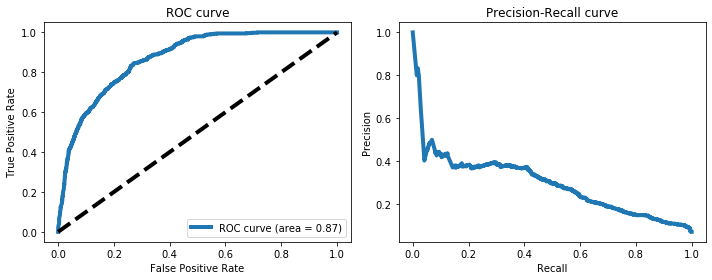

In [671]:
y_pp = pd.DataFrame(pipe_bc_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout()
plt.show()

#### Naive Bayes Classifier

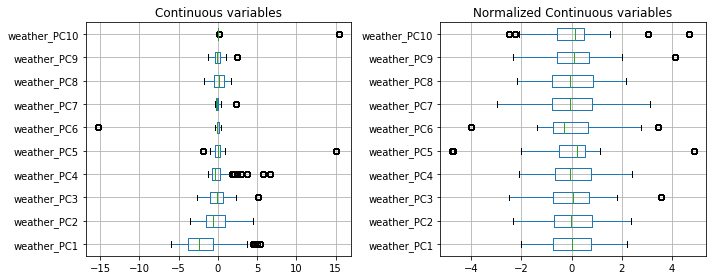

In [500]:
pt = PowerTransformer(standardize=True)
X_dum_pt = pd.DataFrame(pt.fit_transform(X_dum), columns=X_dum.columns, index=X_dum.index)

fig,ax = plt.subplots(ncols=2, figsize=(10,4))
X_dum.loc[:,'weather_PC1':'weather_PC10'].boxplot(vert=False, ax=ax[0]);
ax[0].set_title('Continuous variables')
X_dum_pt.loc[:,'weather_PC1':'weather_PC10'].boxplot(vert=False, ax=ax[1]);
ax[1].set_title('Normalized Continuous variables')
plt.tight_layout();

In [639]:
sm_nb_gaussian = SMOTE()
ovr = RandomOverSampler()

# GaussianNB for continuous features:
nb_gaussian = naive_bayes.GaussianNB()
params = {'nb_gaussian__var_smoothing':np.logspace(-10,0,5)}
    
pipeline = Pipeline([('std', std), ('sm_nb_gaussian', sm_nb_gaussian), ('nb_gaussian', nb_gaussian)])

gs_nb_gaussian = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_gaussian.fit(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'], y)
print(gs_nb_gaussian.best_params_)
print(gs_nb_gaussian.best_score_)

# MultinomialNB for categorical features:
nb_multinomial = naive_bayes.MultinomialNB()
params = {'nb_multinomial__alpha':np.linspace(0.1,1.0,5)}

pipeline = Pipeline([('ovr', ovr),
                     ('nb_multinomial', nb_multinomial)])

X_dum_multinb = pd.get_dummies(X[['Species','Trap']])

gs_nb_multinomial = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_multinomial.fit(X_dum_multinb, y)
print(gs_nb_multinomial.best_params_)
print(gs_nb_multinomial.best_score_)

# BernoulliNB for binary features:
nb_bernoulli = naive_bayes.BernoulliNB()
params = {'nb_bernoulli__alpha':np.linspace(0.1,1.0,5)}

pipeline = Pipeline([('ovr', ovr),
                     ('nb_bernoulli', nb_bernoulli)])

gs_nb_bernoulli = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_bernoulli.fit(X[['isSpray']], y)
print(gs_nb_bernoulli.best_params_)
print(gs_nb_bernoulli.best_score_)

# Combining Naive Bayes classifiers:


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  22 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'nb_gaussian__var_smoothing': 1.0}
0.6348076828940716
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'nb_multinomial__alpha': 1.0}
0.6893712986078632
Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'nb_bernoulli__alpha': 0.1}
0.505192057954489


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.5s finished


In [650]:
nb_gaussian_best = naive_bayes.GaussianNB(var_smoothing=1.0)
pipeline_best_nb_gau = Pipeline([('std', std), ('sm_nb_gaussian', sm_nb_gaussian), ('nb_gaussian_best', nb_gaussian_best)])

pipeline_best_nb_gau.fit(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'], y)
a_gau = pipeline_best_nb_gau.predict_proba(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'])
a_gau

array([[0.36625974, 0.63374026],
       [0.36625974, 0.63374026],
       [0.36625974, 0.63374026],
       ...,
       [0.56266322, 0.43733678],
       [0.56266322, 0.43733678],
       [0.56266322, 0.43733678]])

In [641]:
nb_bernoulli_best = naive_bayes.BernoulliNB(alpha=0.1)
pipeline_best_nb_ber = Pipeline([('ovr' , ovr), ('nb_bernoulli_best', nb_bernoulli_best)])
pipeline_best_nb_ber.fit(X[['isSpray']], y)
a_ber = pipeline_best_nb_ber.predict_proba(X[['isSpray']])
a_ber

array([[0.50275877, 0.49724123],
       [0.50275877, 0.49724123],
       [0.50275877, 0.49724123],
       ...,
       [0.50275877, 0.49724123],
       [0.50275877, 0.49724123],
       [0.50275877, 0.49724123]])

In [642]:
nb_multinomial_best = naive_bayes.MultinomialNB(alpha=1.0)
pipeline_best_nb_mul = Pipeline([('ovr' , ovr), ('nb_multinomial_best', nb_multinomial_best)])
pipeline_best_nb_mul.fit(X_dum_multinb, y)
a_mul = pipeline_best_nb_mul.predict_proba(X_dum_multinb)
a_mul

array([[0.3004797 , 0.6995203 ],
       [0.58391175, 0.41608825],
       [0.98680352, 0.01319648],
       ...,
       [0.63380683, 0.36619317],
       [0.25133136, 0.74866864],
       [0.28498066, 0.71501934]])

In [677]:
y.value_counts(normalize=True).values

array([0.94755378, 0.05244622])

In [678]:
(a_ber*a_mul*a_gau)/y.value_counts(normalize=True).values

array([[0.05839291, 4.20304997],
       [0.11347291, 2.50005569],
       [0.19176779, 0.07929072],
       ...,
       [0.18921747, 1.51837545],
       [0.07503277, 3.10426353],
       [0.08507847, 2.96474079]])

#### Support Vector Machines

In [34]:
svm = SVC(kernel='rbf')
params = {'svm__C':np.logspace(-4,4,5),
          'svm__gamma':np.logspace(-4,4,5)}
    
pipeline = Pipeline([('std', std), ('sm', sm), ('svm', svm)])

gs_svm = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_svm.fit(X_dum, y)
print(gs_svm.best_params_)
print(gs_svm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 38.9min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed: 89.8min finished


{'svm__C': 100.0, 'svm__gamma': 0.01}
0.7503429108301031


In [459]:
# Pickle if results are satisfactory:
gs_svm_pickle_name = './pickle_objects/gs_svm_best_score_{}%.pkl'.format(np.round(gs_svm.best_score_*100,2))
pickle.dump(gs_svm.best_estimator_, open(gs_svm_pickle_name, 'wb'))

NameError: name 'gs_svm' is not defined

### Append predicts

In [ ]:
# Reload .pkl objects on restart:
Tk().withdraw()
pipe_lr_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_dt_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_rf_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_bc_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_gb_best = pickle.load(open(askopenfilename(), 'rb'))

In [ ]:
train_predict_df = train_df.copy()
pipe_lr_best.fit(X_dum, y)
train_predict_df['lr_predict'] = pipe_lr_best.predict(X_dum)
pipe_dt_best.fit(X_dum, y)
train_predict_df['dt_predict'] = pipe_dt_best.predict(X_dum)
pipe_rf_best.fit(X_dum, y)
train_predict_df['rf_predict'] = pipe_rf_best.predict(X_dum)
pipe_bc_best.fit(X_dum, y)
train_predict_df['bc_predict'] = pipe_bc_best.predict(X_dum)
pipe_gb_best.fit(X_dum, y)
train_predict_df['gb_predict'] = pipe_gb_best.predict(X_dum)
train_predict_df.to_csv('./datasets/train_predict_df.csv')
train_predict_df.head(1)

### TensorFlow Keras Neural Network

In [272]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
metric = tf.keras.metrics.AUC()

def create_model(epochs, optimizer, batch_size, kernel_initializer_fn, kernel_regularizer_fn):
    tf_keras = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_dum.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    
    tf_keras.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=[metric])
    return tf_keras

In [273]:
kerasclf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)
params = {'kerasclf__epochs': [100],
          'kerasclf__optimizer': ['sgd','adam'],
          'kerasclf__batch_size': [5, 10, 20],
          'kerasclf__kernel_initializer_fn': ['glorot_uniform', 'normal', 'uniform'],
          'kerasclf__kernel_regularizer_fn': ['L1L2']}
          
pipeline = Pipeline([('std', std), ('sm', sm), ('kerasclf', kerasclf)])

gs_keras = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_keras.fit(X_dum, y)
print(gs_keras.best_params_)
print(gs_keras.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 494.8min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed: 609.7min finished


Train on 19910 samples
Epoch 1/100
19910/19910 [==============================] - 6s 312us/sample - loss: 0.4134 - auc_4: 0.9038
Epoch 2/100
19910/19910 [==============================] - 4s 220us/sample - loss: 0.3029 - auc_4: 0.9449
Epoch 3/100
19910/19910 [==============================] - 4s 212us/sample - loss: 0.2837 - auc_4: 0.9512
Epoch 4/100
19910/19910 [==============================] - 4s 225us/sample - loss: 0.2846 - auc_4: 0.9502
Epoch 5/100
19910/19910 [==============================] - 5s 248us/sample - loss: 0.2737 - auc_4: 0.9536
Epoch 6/100
19910/19910 [==============================] - 5s 229us/sample - loss: 0.2629 - auc_4: 0.9566
Epoch 7/100
19910/19910 [==============================] - 4s 210us/sample - loss: 0.2572 - auc_4: 0.9577
Epoch 8/100
19910/19910 [==============================] - 4s 211us/sample - loss: 0.2570 - auc_4: 0.9579
Epoch 9/100
19910/19910 [==============================] - 4s 211us/sample - loss: 0.2539 - auc_4: 0.9588s - loss: 0.2608 - a - E

19910/19910 [==============================] - 4s 210us/sample - loss: 0.2215 - auc_4: 0.9672
Epoch 73/100
19910/19910 [==============================] - 4s 210us/sample - loss: 0.2248 - auc_4: 0.9662s - loss:
Epoch 74/100
19910/19910 [==============================] - 4s 208us/sample - loss: 0.2271 - auc_4: 0.9651
Epoch 75/100
19910/19910 [==============================] - 4s 208us/sample - loss: 0.2240 - auc_4: 0.9663
Epoch 76/100
19910/19910 [==============================] - 4s 207us/sample - loss: 0.2291 - auc_4: 0.9650s - loss: 0.2293
Epoch 77/100
19910/19910 [==============================] - 4s 209us/sample - loss: 0.2260 - auc_4: 0.9652
Epoch 78/100
19910/19910 [==============================] - 4s 208us/sample - loss: 0.2286 - auc_4: 0.9652
Epoch 79/100
19910/19910 [==============================] - 4s 209us/sample - loss: 0.2261 - auc_4: 0.9659
Epoch 80/100
19910/19910 [==============================] - 4s 220us/sample - loss: 0.2197 - auc_4: 0.9669
Epoch 81/100
19910/19910 

In [275]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

model = create_model(epochs=gs_keras.best_params_['kerasclf__epochs'],
                     optimizer=gs_keras.best_params_['kerasclf__optimizer'],
                     batch_size=gs_keras.best_params_['kerasclf__batch_size'],
                     kernel_initializer_fn=gs_keras.best_params_['kerasclf__kernel_initializer_fn'],
                     kernel_regularizer_fn=gs_keras.best_params_['kerasclf__kernel_regularizer_fn'],)

history = model.fit(X_dum, y.values,
                    epochs=gs_keras.best_params_['kerasclf__epochs'],
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop])

Train on 8404 samples, validate on 2102 samples
Epoch 1/100
8404/8404 [==============================] - 3s 315us/sample - loss: 0.3810 - auc_4: 0.4982 - val_loss: 0.3865 - val_auc_4: 0.5706
Epoch 2/100
8404/8404 [==============================] - 1s 114us/sample - loss: 0.1837 - auc_4: 0.5715 - val_loss: 0.3991 - val_auc_4: 0.5868
Epoch 3/100
8404/8404 [==============================] - 1s 135us/sample - loss: 0.1736 - auc_4: 0.5924 - val_loss: 0.4006 - val_auc_4: 0.5474
Epoch 4/100
8404/8404 [==============================] - 1s 115us/sample - loss: 0.1708 - auc_4: 0.5962 - val_loss: 0.3958 - val_auc_4: 0.5518
Epoch 5/100
8404/8404 [==============================] - 1s 100us/sample - loss: 0.1585 - auc_4: 0.6703 - val_loss: 0.4563 - val_auc_4: 0.5534
Epoch 6/100
8404/8404 [==============================] - 1s 98us/sample - loss: 0.1589 - auc_4: 0.6734 - val_loss: 0.4597 - val_auc_4: 0.5545
Epoch 7/100
8404/8404 [==============================] - 1s 116us/sample - loss: 0.1522 - auc_4

In [190]:
model.evaluate(X_dum, y.values, verbose=2)

10506/10506 - 0s - loss: 0.2026 - accuracy: 0.9476


[0.2026377199839423, 0.94755375]

In [277]:
sorted(model.predict(X_dum), reverse=True) # why just prob of 0?

[array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 array([0.17162323], dtype=float32),
 

In [208]:
roc_auc_score(y, model.predict(X_dum))

0.6255329563799348

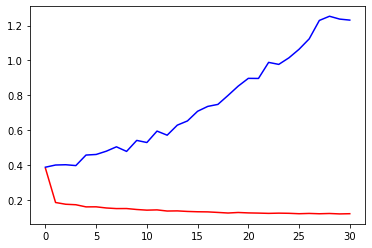

In [276]:
plt.plot(history.history['loss'],c='r')
plt.plot(history.history['val_loss'],c='b')
plt.show()

In [653]:
    # To-Do:
# Make a final train_with_predict_df including all the predicts in separate columns.
# Visualise them in a paged story.

# Add sampling strategy as hyperparameter in gridsearches
# How can I combine the NB classifiers?